# 1.1「学習済みVGGモデル」を使用する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、未知の画像（ゴールデンレトリバー）を分類します


# 学習目標

1.	PyTorchでImangeNetデータセットでの学習済みモデルをロードできるようになる
2.	VGGモデルについて理解する
3.	入力画像のサイズや色を変換できるようになる



# 事前準備


1. 書籍の指示に従い、make_folders_and_data_downloads.ipynbを実行して、本章で使用するデータをダウンロード


2. PyTorchのインストールページ（ https://pytorch.org/get-started/locally/ ）を参考に、PyTorch1.0をインストール


conda install pytorch-cpu torchvision-cpu -c pytorch

（Windowsで、GPUなしの環境をcondaでインストールする場合）


3. Matplotlibをインストール

conda install -c conda-forge matplotlib 


# パッケージのimportとPyTorchのバージョンを確認

In [3]:
# パッケージのimport
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms


In [4]:
# PyTorchのバージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


# VGG-16の学習済みモデルをロード

In [5]:
# 学習済みのVGG-16モデルをロード
# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# 入力画像の前処理クラスを作成

In [10]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)


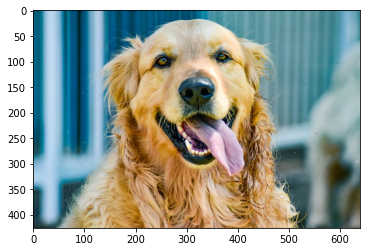

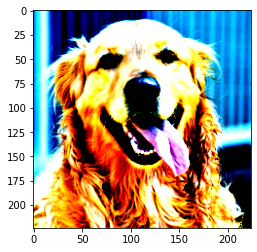

In [11]:
# 画像前処理の動作を確認

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示 これは表示用のため。
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.savefig("test.png")
plt.show()



# 出力結果からラベルを予測する後処理クラスを作成

In [12]:
# ILSVRCのラベル情報をロードし辞意書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index


{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [7]:
# 出力結果からラベルを予測する後処理クラス
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める。

    Attributes
    ----------
    class_index : dictionary
            クラスindexとラベル名を対応させた辞書型変数。
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        確率最大のILSVRCのラベル名を取得する。

        Parameters
        ----------
        out : torch.Size([1, 1000])
            Netからの出力。

        Returns
        -------
        predicted_label_name : str
            最も予測確率が高いラベルの名前
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name


# 学習済みVGGモデルで手元の画像を予測

In [8]:
# ILSVRCのラベル情報をロードし辞意書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictorのインスタンスを生成します
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 入力画像を読み込む
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 前処理の後、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)  # 前処理クラス作成
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])

# モデルに入力し、モデル出力をラベルに変換する
out = net(inputs)  # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 予測結果を出力する
print("入力画像の予測結果：", result)


入力画像の予測結果： golden_retriever


以上